# Pulse counting

While QICK was originally developed for RF pulse generation and readout, the high-speed digitization capabilities of the RF-ADCs are also useful for detecting and analyzing DC-coupled baseband pulses.
This makes QICK useful for photon counting and timing, and thus for quantum sensing (NV centers) and quantum networking (SNSPD timing).

We'll use two identical generators (of the "interpolated" type), and connect them to the following:
* A regular QICK readout, to see the full waveform and demonstrate the pulse-counting mode of this readout. The pulse-counting mode was added to QICK by the Sandia Lab developers of the QICK-DAWG project (https://github.com/sandialabs/qick-dawg), and is standard in new QICK firmwares.
    * See more extensive demos in  https://github.com/openquantumhardware/qick/blob/main/qick_demos/09_photon_counting.ipynb and https://github.com/sandialabs/qick-dawg/blob/zcu216/jupyter_notebooks/photon_counting_demo.ipynb.
* A "time tagger" readout, to get both pulse counts and times. The time tagger is exclusively meant for digitizing baseband pulses, and is being gradually rolled out in new QICK firmwares.

We will use the QICK box. Connect as follows:
* DC-out daughtercard in the 3rd DAC slot (ports 12-15). 
* DC-in daughtercard in the 0th ADC slot (ports 0-1). 
* DAC port 12 -> ADC port 0
* DAC port 13 -> ADC port 1

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import time

from qick import *
from qick.rfboard import RFQickSoc216V1

# the main program class
from qick.asm_v2 import AveragerProgramV2

In [2]:
# # crank up the logging (optional)
# import logging
# # logging.basicConfig(level=logging.DEBUG)
# logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

# # list(logging.root.manager.loggerDict.keys())
# # suppress the start/stop messages from the tproc logger
# logging.getLogger('qick_processor').setLevel(logging.WARNING)

In order to eliminte jitter, we need the generator and readout clocks to be in integer-ratio relation. We can get this by changing the DAC sampling clocks when we load the firmware (see https://docs.qick.dev/latest/topics/changing_fs.html).

Note the following:
* Each readout channel has a buffer with the edge-counting capability.
* There's one time-tagger block, which is connected to a single ADC.

In [3]:
# Load bitstream
soc = RFQickSoc216V1('fw/2025-08-15_216_tprocv2r26_rfbv2_standard/qick_216_rfbv2.bit',
                     dac_sample_rates={1: 4915.2, 2: 4915.2, 3: 4915.2},
                    )

soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.363

Firmware configuration (built Sat Aug 16 12:14:08 2025):

	Global clocks (MHz): tProc dispatcher timing 307.200, RF reference 245.760
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 1, ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228 on JHC1, or QICK box DAC port 0
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228 on JHC2, or QICK box DAC port 1
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 32768 complex samples (3.419 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228 on JHC1, or QICK box DAC port 2
	3:	axis_signal_ge

Channel numbers and constants:

In [4]:
# firmware channel numbers for generators, readout, and time tagger
GEN_CH_RO=12 # the generator connected to the regular readout
GEN_CH_TT=13 # the generator connected to the time tagger
RO_CH=10
TT_BLK=0

# physical DAC and ADC ports
DAC_RO=12
DAC_TT=13
ADC_RO=0
ADC_TT=1

# gain for the DC-coupled amplifers on the DC-in daughterboard
ADC_GAIN = 0 # dB, -6 through 26

# trigger time for the regular readout, to align the readout window with the pulses
TRIG_TIME_RO = 0.4
# trigger time for the time-tagger, to align the arm window with the pulses
TRIG_TIME_TT = 0.1
# number of pulses we'll play per shot
N_PULSES = 4

Configure the daughtercards.

In [5]:
soc.rfb_set_dac_dc(DAC_TT)
soc.rfb_set_dac_dc(DAC_RO)
soc.rfb_set_adc_dc(ADC_TT, gain=ADC_GAIN)
soc.rfb_set_adc_dc(ADC_RO, gain=ADC_GAIN);

### Calibration

By default the ADCs self-calibrate continuously, which performs adequately for RF signals.
For DC-coupled pulses, it's useful to intentionally calibrate the ADCs; otherwise the calibration tends to drift, and their construction (8 "sub-ADCs" operating in parallel) creates periodic patterns in the output data.

Calibrating an ADC requires feeding it with a low-frequency RF tone between 0 and -40 dB full-scale, allowing the self-calibration to run, and then freezing the calibration before removing the calibration signal. (See https://docs.amd.com/r/en-US/pg269-rf-data-converter/Background-Calibration-Process.)

In [6]:
class CalProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        for gen_ch in cfg['gen_chs']:
            self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)
            self.add_pulse(ch=gen_ch, name="myconst%d"%(gen_ch),
                           style="const", 
                           length=1.0, 
                           freq=cfg['freq'],
                           phase=0,
                           gain=1.0,
                           mode='periodic', # play repeatedly, forever
                          )

    def _body(self, cfg):
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="myconst%d"%(gen_ch), t=0)
        
calcfg = {'gen_chs': [GEN_CH_TT, GEN_CH_RO],
          'freq': 100,
         }
calprog = CalProgram(soccfg, reps=1, final_delay=0.5, cfg=calcfg)

# run the program, which will play a continuous calibration tone
calprog.run(soc)

adcs = []
adcs.append(soccfg['readouts'][RO_CH]['adc'])
adcs.extend(soccfg['time_taggers'][TT_BLK]['adcs'])

# enable ADC calibration for 1 second, then freeze the calibration
soc.unfreeze_adc_cals(adcs)
time.sleep(1)
soc.freeze_adc_cals(adcs)

# stop playing the calibration tone
soc.reset_gens()

## Regular readout buffer, edge-counting mode

Here's the program we'll use for this demo, which does the following:
* plays four square pulses, at an interval of 0.2 us, on each of the two generators
  * these are baseband pulses; the edge-counting readout (which operates on the downconverted+decimated data) can also work with RF pulses, the time tagger (which operates on raw ADC samples) cannot
* reads out the regular readout
  * optionally configures this readout for edge-counting mode instead of averaging mode
* optionally arms the time tagger

In [7]:
class ArmingProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        
        for gen_ch in cfg['gen_chs']:
            self.declare_gen(ch=gen_ch, nqz=1, mixer_freq=0)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'],
                             edge_counting=cfg['counting_ro'],
                             high_threshold=cfg['counting_hithresh'],
                             low_threshold=cfg['counting_lothresh'],        
                            )
        self.add_pulse(ch=cfg['gen_chs'], name="myconst",
                       style="const", 
                       length=0.05,
                       freq=0, 
                       phase=0,
                       gain=1.0,
                      )
        
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=0,
                               outsel='input',
                              )
        
        # configure the regular readout
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)

    def _body(self, cfg):
        if cfg['arm_tt']:
            self.trigger(tts=[cfg['tt_blk']], t=cfg['trig_time_tt'], width=cfg['ro_len'])
        self.trigger(ros=[cfg['ro_ch']], t=cfg['trig_time_ro'])

        # play 4 pulses, 0.2 us apart
        for ich, gen_ch in enumerate(cfg['gen_chs']):
            for ipulse in range(N_PULSES):
                self.pulse(ch=gen_ch, name="myconst", t=0.2*ipulse, tag="%d_%d"%(ipulse, ich))
            
config = {'gen_chs': [GEN_CH_TT, GEN_CH_RO], # generators to play pulses on
          'ro_ch': RO_CH, # the regular readout
          'tt_blk': TT_BLK, # the regular readout
          'ro_len': 0.8, # readout window for the regular readout and time-tagger [us]
          'trig_time_ro': TRIG_TIME_RO, # trigger time for the regular readout [us]
          'trig_time_tt': TRIG_TIME_TT, # arming time for the time-tagger [us]
          'arm_tt': False, # whether to arm the time-tagger inside the program
          'counting_ro': False, # whether to run the regular readout in counting or averaging mode
          'counting_hithresh': None, # high threshold for counting mode [arb. readout units]
          'counting_lothresh': None, # low threshold for counting mode [arb. readout units]
         }

If we run the regular readout in decimated mode, we see the pulse train we generated.

  0%|          | 0/1 [00:00<?, ?it/s]

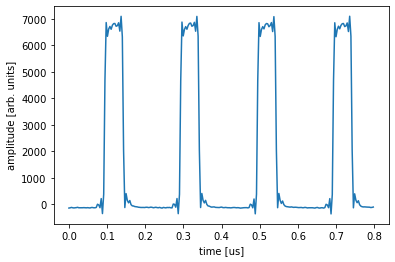

In [8]:
prog = ArmingProgram(soccfg, reps=1, final_delay=2.0, cfg=config)

iq_list = prog.acquire_decimated(soc)
t = prog.get_time_axis(0)
samples = iq_list[0][:,0]
plt.plot(t, samples)

# # show the Schmitt-trigger thresholds
# plt.axhline(config['counting_hithresh']+0.5, color='purple')
# plt.axhline(config['counting_lothresh']-0.5, color='purple')

plt.ylabel("amplitude [arb. units]")
plt.xlabel("time [us]");

If we run the regular readout in averaging mode, we get the average of the decimated samples.

In [9]:
prog = ArmingProgram(soccfg, reps=1, final_delay=2.0, cfg=config)
iq_list = prog.acquire(soc)
print("average amplitude: %f" %(iq_list[0][0,0]))

  0%|          | 0/1 [00:00<?, ?it/s]

average amplitude: 1578.247967


Now let's switch to counting mode.
The edge-counting mode uses a threshold with hysteresis (aka Schmitt trigger) to reduce double-triggering:
give it a high and a low threshold, where an edge is only counted if the signal rises from the low to the high threshold.

Having done that, we get the number of pulses.

In [10]:
config['counting_ro'] = True
config['counting_hithresh'] = 4000 # high threshold for counting mode [arb. readout units]
config['counting_lothresh'] = 2000 # low threshold for counting mode [arb. readout units]

prog = ArmingProgram(soccfg, reps=1, final_delay=2.0, cfg=config)
iq_list = prog.acquire(soc)
print("pulse count: %f" %(iq_list[0][0,0]))

  0%|          | 0/1 [00:00<?, ?it/s]

pulse count: 4.000000


Now let's run a repeated measurement.

In the same way that normally (with averaged readout) you can get shot-by-shot averaged amplitudes using `get_raw()`, you can get shot-by-shot pulse counts.

In [11]:
prog = ArmingProgram(soccfg, reps=10, final_delay=2.0, cfg=config)
iq_list = prog.acquire(soc)
print("average pulse count: %f" %(iq_list[0][0,0]))
print("shot-by-shot pulse counts: %s" % (prog.get_raw()[0][:,0,0]))

  0%|          | 0/10 [00:00<?, ?it/s]

average pulse count: 4.000000
shot-by-shot pulse counts: [4 4 4 4 4 4 4 4 4 4]


To summarize: the edge-counting mode is an easy way to do pulse counting in QICK with a minimal learning curve, since it uses the same interfaces and datapaths as averaging readout.

### Time tagger

In [12]:
def plot_tags(soc, soccfg, blk, nsamp, tt_dt):
    """Read the time-tagger memories. Print the times, plot the samples.
    """
    ttcfg = soccfg['time_taggers'][blk]
    
    arms = soc.tt_readmem(blk, 'ARM')
    tags = soc.tt_readmem(blk, 'TAG0')
    smps = soc.tt_readmem(blk, 'SMP')
    print("total tags:", len(tags))
    print("tags per arming window:", arms)

    t = np.arange(nsamp*8)/(8*ttcfg['f_fabric'])
    if len(smps) > 0 and len(arms) > 0:
        # be lazy, assume that we have the same number of tags in every shot
        # (instead of using the ARM array)
        tags = tags.reshape((-1, N_PULSES))
        
        # print raw tag values
        print("tags [raw units]:")
        for x in tags: print(x)

        # print tags in real units
        tag_times = tags*tt_dt
        t_ref = tag_times[0,0]
        print("tags relative to %f [ns]:" % (t_ref))
        for x in tag_times: print(x - t_ref)

        # plot the samples
        for iShot, armsamps in enumerate(smps.reshape((-1, N_PULSES, nsamp*8))):
            for iTag, samps in enumerate(armsamps):
                plt.plot(t, samps, label='shot %d, tag %d'%(iShot, iTag))
        plt.legend()
        plt.ylabel("amplitude [arb. units]")
        plt.xlabel("time [us]");

The time tagger counts pulses and records their times.
It can also capture a small time window for each pulse.

The algorithm for edge detection and time measurement can be configured in several ways; here we use 4-bit interpolation, which improves the time resolution to 1/16 of the ADC sample interval.

In [13]:
TT_NSAMP = 20 # units of ADC fabric ticks
TT_THRESHOLD = 3000 # units of amplitude, as measured by time-tagger
TT_INTERP = 4 # number of bits for interpolation

# calculate the time resolution after interpolation
tt_dt = 1e3/(soccfg['time_taggers'][TT_BLK]['f_fabric'] * 8 * 2**TT_INTERP)

print("time-tag resolution is %f ns" % (tt_dt))

soc.tt_config(TT_BLK,
             threshold=TT_THRESHOLD,
             wr_smp=TT_NSAMP,
             filt=False,
             slope=False,
             invert=False,
             interp=TT_INTERP,
             deadtime=30, # units of ADC fabric ticks
             )

time-tag resolution is 0.025431 ns


The time tagger captures pulses only while it is armed; pulse times (tags) are defined relative to the start of the arming window.

The simplest way to use the time tagger is to arm it from software, capturing all of the pulses in a single arm window.

We'll run two shots.
We see that all 8 pulses are measured relative to a large (tens of ms) offset, because the time tagger is armed a long time before the program actually runs.


  0%|          | 0/1 [00:00<?, ?it/s]

total tags: 8
tags per arming window: [8]
tags [raw units]:
[1203669648 1203677457 1203685393 1203693201]
[1203795473 1203803281 1203811217 1203819025]
tags relative to 30610902.099609 [ns]:
[  0.         198.59313965 400.41605632 598.98376465]
[3199.89522298 3398.46293132 3600.28584798 3798.85355632]


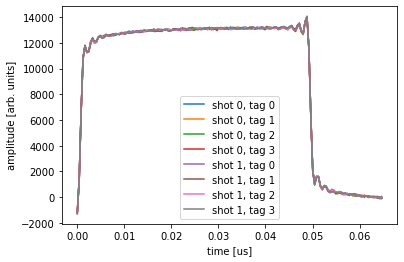

In [14]:
config['arm_tt'] = False
prog = ArmingProgram(soccfg, reps=2, final_delay=2.0, cfg=config)

soc.tt_reset(TT_BLK)
soc.tt_arm(TT_BLK)
iq_list = prog.acquire_decimated(soc)
soc.tt_disarm(TT_BLK)

plot_tags(soc, soccfg, TT_BLK, TT_NSAMP, tt_dt)

Now we switch to arming the time tagger for each shot, from inside the QICK program.

We now get the tags for each shot relative to the shot time.

  0%|          | 0/1 [00:00<?, ?it/s]

total tags: 8
tags per arming window: [4 4]
tags [raw units]:
[ 5137 12945 20881 28689]
[ 5137 12945 20881 28689]
tags relative to 130.640666 [ns]:
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]


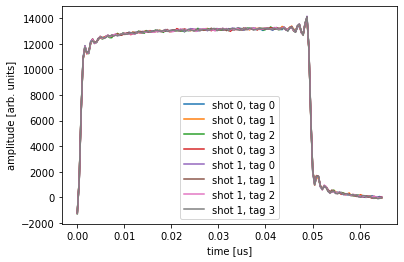

In [15]:
config['arm_tt'] = True
prog = ArmingProgram(soccfg, reps=2, final_delay=2.0, cfg=config)

soc.tt_reset(TT_BLK)
iq_list = prog.acquire_decimated(soc)
plot_tags(soc, soccfg, TT_BLK, TT_NSAMP, tt_dt)

Those times are not exactly 0.2 us apart - is this what we expect?

We check the program pulse times, and confirm that the measured times match the as-compiled times (which are rounded to the nearest tProcessor clock tick).

In [16]:
times = [prog.get_time_param("%d_0"%(i), "t")*1e3 for i in range(4)]
print("as-compiled pulse times [ns]: %s" % (times))

as-compiled pulse times [ns]: [0.0, 198.56770833333334, 400.390625, 598.9583333333334]


Repeat with more shots - we see that there's no measurable jitter.

In [17]:
prog = ArmingProgram(soccfg, reps=20, final_delay=2.0, cfg=config)

soc.tt_reset(TT_BLK)
prog.run_rounds(soc)
tags = soc.tt_readmem(TT_BLK, 'TAG0')

tag_times = tags.reshape((-1,4))*tt_dt
t_ref = tag_times[0,0]
print("tags relative to %f [ns]:" % (t_ref))
for x in tag_times: print(x - t_ref)

  0%|          | 0/20 [00:00<?, ?it/s]

tags relative to 130.640666 [ns]:
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.95833333]
[  0.         198.56770833 400.390625   598.9583

In [18]:
# config['arm_tt'] = True
# prog = ArmingProgram(soccfg, reps=1000, final_delay=20.0, cfg=config)

# for i in tqdm(range(20)):
#     soc.tt_reset(TT_BLK)
#     prog.run_rounds(soc, progress=False)
#     tags = soc.tt_readmem(TT_BLK, 'TAG0')
#     tags = tags.reshape((-1,4))
#     print(tags.mean(axis=0))
# #     time.sleep(1)